Stage 1 - Simulating Rapid Adiabatic Passage on a physical qubit
The Hamiltonian describing the system is:

$H(t) = \Omega(t)\sigma_{x} + \Delta(t)\sigma_{z}$

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [253]:
def print_quantum_state_as_superposition(state):
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)
        if abs_amplitude > 1e-10:
            sign = '-' if amplitude.real < 0 else ''
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign}{abs_amplitude:.2f}|{binary_state}⟩")

    superposition_str = ' + '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

Text(0.5, 1.0, 'Pulses over time')

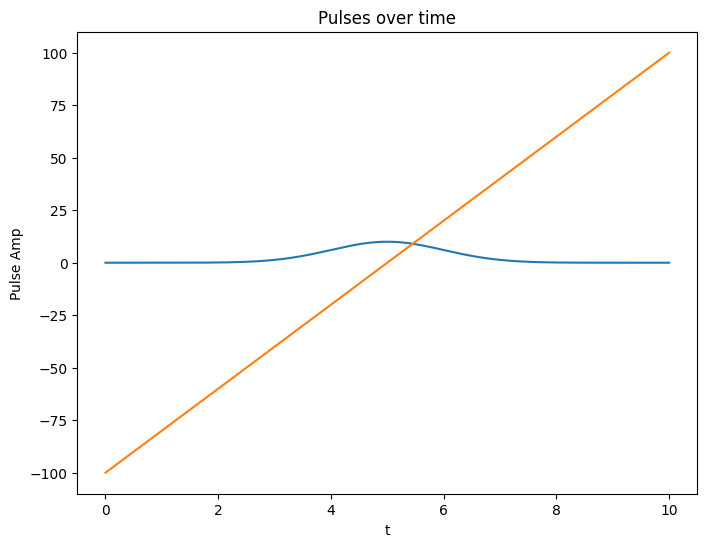

In [134]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_t = 10 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t = 100*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t)
plt.plot(t, delta_t)
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.title("Pulses over time")


Generating the Hamiltonian and solving using mesolve

Text(0, 0.5, 'Logic state')

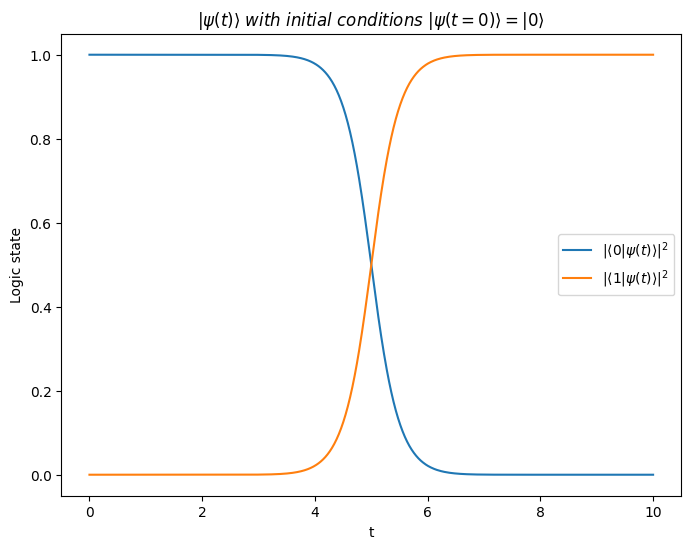

In [135]:
H = [[sigmax(), omega_t], [sigmaz(), delta_t]]

psi0 = basis(2, 0)
psi1 = basis(2, 1)

output = mesolve(H, psi0, t)

expect_psi_0 = []
expect_psi_1 = []
for state in output.states:
    expect_stat_psi_0 = np.abs(psi0.overlap(state))**2
    expect_stat_psi_1 = np.abs(psi1.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)
    
eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

plt.figure(figsize=(8, 6))

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = | 0 \rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0 | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1 | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Logic state")

Stage 1.1 - Adding noise

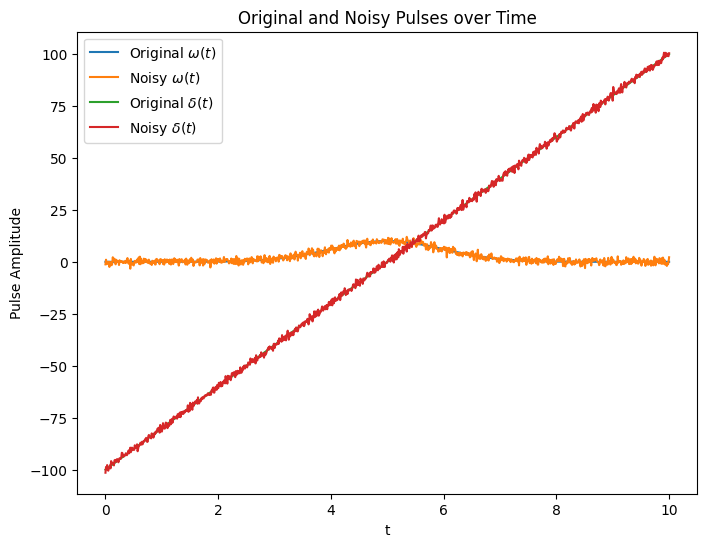

In [165]:
# Adding noise to the pulses
t = np.linspace(0, T, 1000)
noise_strength = 1
omega_t_noisy = omega_t + noise_strength * np.random.normal(size=len(t))
delta_t_noisy = delta_t + noise_strength * np.random.normal(size=len(t))

# Plot the original and noisy pulses
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'Original $\omega(t)$')
plt.plot(t, omega_t_noisy, label=r'Noisy $\omega(t)$')
plt.plot(t, delta_t, label=r'Original $\delta(t)$')
plt.plot(t, delta_t_noisy, label=r'Noisy $\delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amplitude")
plt.title("Original and Noisy Pulses over Time")
plt.legend()
plt.show()

Solving the noisy Hamiltonian

Text(0, 0.5, 'Logic state')

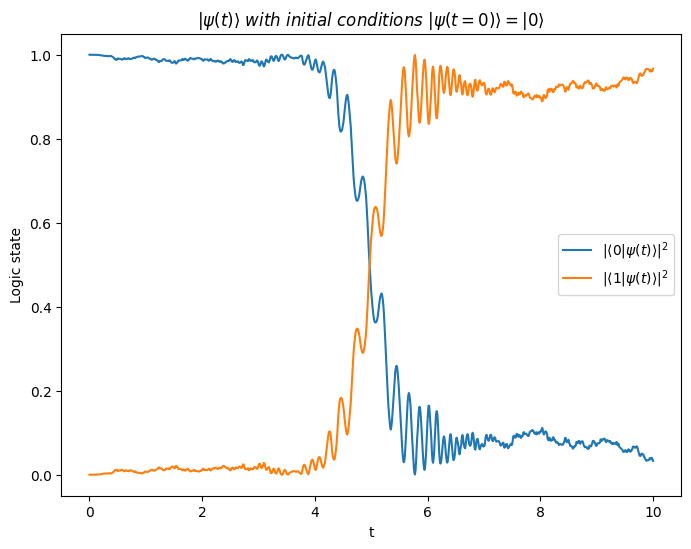

In [166]:
H_noisy = [[sigmax(), omega_t_noisy], [sigmaz(), delta_t_noisy]]

psi0 = basis(2, 0)
psi1 = basis(2, 1)

output = mesolve(H_noisy, psi0, t)

expect_psi_0 = []
expect_psi_1 = []
for state in output.states:
    expect_stat_psi_0 = np.abs(psi0.overlap(state))**2
    expect_stat_psi_1 = np.abs(psi1.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)
    
eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

plt.figure(figsize=(8, 6))

plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = | 0 \rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0 | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1 | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Logic state")

Stage 2 - Generating the logic space and checking if ARP manages to move the logic zero to logic one 

Working with the stabilizer formalism

In [302]:
def is_stabilized(state, stabilizers):
    stabilized = True
    syndrome = []
    overlaps = []
    for stabilizer in stabilizers:
        overlap = state.overlap(stabilizer * state)
        overlaps.append(np.abs(overlap))
        if not np.abs(overlap) > 0.99:
            stabilized = False
            syndrome.append(1)
        else:
            syndrome.append(0)
    return syndrome, stabilized, overlaps

In [279]:
def print_quantum_state_as_superposition(state):
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)
        # Check if the rounded amplitude is non-zero
        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    # Joining with new lines for formatting
    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [325]:
# Define the Pauli matrices
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
stabilizers = [
    tensor(X, Z, Z, X, I),
    tensor(I, X, Z, Z, X),
    tensor(X, I, X, Z, Z),
    tensor(Z, X, I, X, Z)
]

basis_states = [basis(2, 0), basis(2, 1)]

logical_X = tensor(X, X, X, X, X)
# logical_X = -tensor(X, I, Y, Y, I)

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[1], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[0], basis_states[1]) +
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[0], basis_states[1], basis_states[0], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1], basis_states[0]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[1], basis_states[1]) -
                tensor(basis_states[1], basis_states[0], basis_states[0], basis_states[0], basis_states[1]) -
                tensor(basis_states[0], basis_states[1], basis_states[1], basis_states[0], basis_states[0]) -
                tensor(basis_states[1], basis_states[0], basis_states[1], basis_states[1], basis_states[1]) +
                tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[0], basis_states[1])).unit()


logical_one = logical_X * logical_zero

# Applying error
error = tensor(I, I, I, I, I)
logical_zero = error * logical_zero

result_zero = is_stabilized(logical_zero, stabilizers)
result_one= is_stabilized(logical_one, stabilizers)
print(f"Logical |0_L> is stabilized: {result_zero[1]} and the syndrom is {result_zero[0]}")
print(f"Logical |1_L> is stabilized: {result_one[1]} and the syndrom is {result_one[0]}")
print(print_quantum_state_as_superposition(logical_zero))
print(print_quantum_state_as_superposition(logical_one))

Logical |0_L> is stabilized: True and the syndrom is [0, 0, 0, 0]
Logical |1_L> is stabilized: True and the syndrom is [0, 0, 0, 0]
|ψ⟩ = 0.25|00000⟩ - 0.25|00011⟩ + 0.25|00101⟩ - 0.25|00110⟩ + 0.25|01001⟩ + 0.25|01010⟩ - 0.25|01100⟩ - 0.25|01111⟩ - 0.25|10001⟩ + 0.25|10010⟩ + 0.25|10100⟩ - 0.25|10111⟩ - 0.25|11000⟩ - 0.25|11011⟩ - 0.25|11101⟩ - 0.25|11110⟩
None
|ψ⟩ = - 0.25|00001⟩ - 0.25|00010⟩ - 0.25|00100⟩ - 0.25|00111⟩ - 0.25|01000⟩ + 0.25|01011⟩ + 0.25|01101⟩ - 0.25|01110⟩ - 0.25|10000⟩ - 0.25|10011⟩ + 0.25|10101⟩ + 0.25|10110⟩ - 0.25|11001⟩ + 0.25|11010⟩ - 0.25|11100⟩ + 0.25|11111⟩
None


Trying to convert a logical zero into a logical one

In [245]:
# Define the Hamiltonian for the 5-qubit system
# H0 = (tensor(sigmax(), I, I, I, I) + 
#       tensor(I, sigmax(), I, I, I) + 
#       tensor(I, I, sigmax(), I, I) + 
#       tensor(I, I, I, sigmax(), I) + 
#       tensor(I, I, I, I, sigmax()))
# H1 = (tensor(sigmaz(), I, I, I, I) + 
#       tensor(I, sigmaz(), I, I, I) + 
#       tensor(I, I, sigmaz(), I, I) + 
#       tensor(I, I, I, sigmaz(), I) + 
#       tensor(I, I, I, I, sigmaz()))

H0 = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H1 = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())

# Define time-dependent Hamiltonian
H = [[H0, omega_t], [H1, delta_t]]
# Apply the RAP Hamiltonian to the logical zero state
output = mesolve(H, logical_zero, t)

|ψ⟩ = 0.25|00000⟩ - 0.25|00011⟩ + 0.25|00101⟩ - 0.25|00110⟩ + 0.25|01001⟩ + 0.25|01010⟩ - 0.25|01100⟩ - 0.25|01111⟩ - 0.25|10001⟩ + 0.25|10010⟩ + 0.25|10100⟩ - 0.25|10111⟩ - 0.25|11000⟩ - 0.25|11011⟩ - 0.25|11101⟩ - 0.25|11110⟩
|ψ⟩ = 0.25|00001⟩ + 0.25|00010⟩ + 0.25|00100⟩ + 0.25|00111⟩ + 0.25|01000⟩ - 0.25|01011⟩ - 0.25|01101⟩ + 0.25|01110⟩ + 0.25|10000⟩ + 0.25|10011⟩ - 0.25|10101⟩ - 0.25|10110⟩ + 0.25|11001⟩ - 0.25|11010⟩ + 0.25|11100⟩ - 0.25|11111⟩


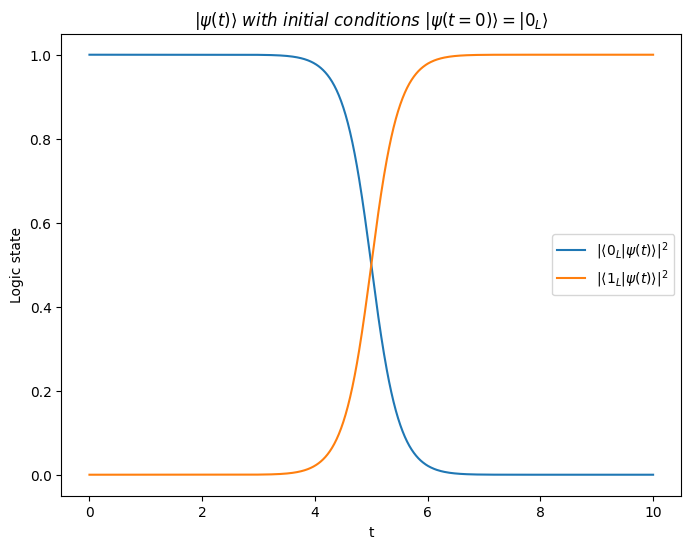

In [315]:
# Expectation values
expect_psi_0 = []
expect_psi_1 = []

for index, state in enumerate(output.states):
    if index == 0 or index == len(output.states) - 1:
        print_quantum_state_as_superposition(state)
    expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
    expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)

eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Logic state")
plt.show()

Checking over a noisy Hamiltonian

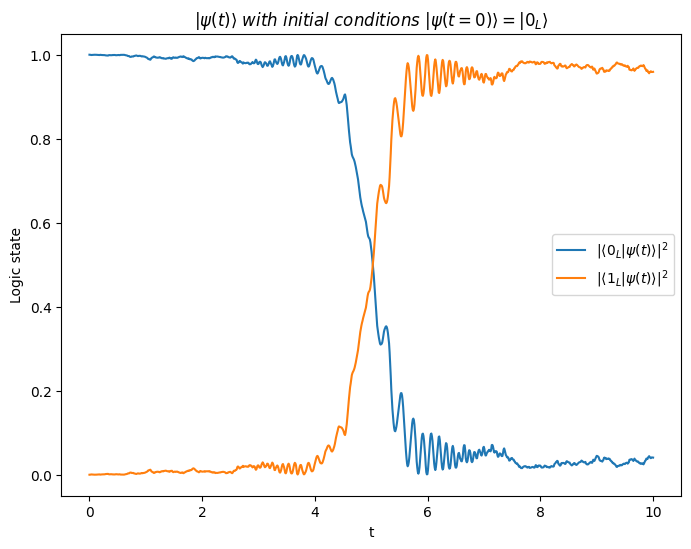

In [336]:
# Adding noise to the pulses
noise_strength = 1
omega_t_noisy = omega_t + noise_strength * np.random.normal(size=len(t))
delta_t_noisy = delta_t + noise_strength * np.random.normal(size=len(t))

H0 = tensor(sigmax(), sigmax(), sigmax(), sigmax(), sigmax())
H1 = tensor(sigmaz(), sigmaz(), sigmaz(), sigmaz(), sigmaz())

H_noisy = [[H0, omega_t_noisy], [H1, delta_t_noisy]]

psi0 = basis(2, 0)
psi1 = basis(2, 1)

output = mesolve(H_noisy, logical_zero, t)

expect_psi_0 = []
expect_psi_1 = []
for index, state in enumerate(output.states):
    expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
    expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
    
    expect_psi_0.append(expect_stat_psi_0)
    expect_psi_1.append(expect_stat_psi_1)

eigenvalues_0 = np.array(expect_psi_0)
eigenvalues_1 = np.array(expect_psi_1)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$')
plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$')
plt.legend()
plt.xlabel("t")
plt.ylabel("Logic state")
plt.show()